# Things to do:

1. Clean data
2. Figure out a way to aggregate watch data
3. Figure out relationships between watch data and sii

4. Predict PCIAT columns without watch data
5. Predict PCIAT columns with watch data
6. Predict sii without watch data
7. Predict sii with watch data

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from IPython.core.magic import register_cell_magic

# Reusable Functions

In [2]:
def remove_outliers(df, columns, n_std=3):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       z_scores = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
       df_clean = df_clean[abs(z_scores) <= n_std]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

def remove_outliers_iqr(df, columns, k=1.5):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       Q1 = df_clean[col].quantile(0.15)
       Q3 = df_clean[col].quantile(0.85)
       IQR = Q3 - Q1
       
       df_clean = df_clean[~((df_clean[col] < (Q1 - k * IQR)) | 
                            (df_clean[col] > (Q3 + k * IQR)))]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

In [83]:
def StandardScale(train_df, test_df, columns_to_ignore):
    
    train_df_to_scale = train_df.drop(columns_to_ignore+['sii'], axis=1)
    if test_df: test_df_to_scale = test_df.drop(columns_to_ignore, axis=1)
    
    scaler = StandardScaler()
    scaler.fit(train_df_to_scale)
    train_df_scaled = pd.DataFrame(scaler.transform(train_df_to_scale), columns=train_df_to_scale.columns, index=train_df.index)
    if test_df: test_df_scaled = pd.DataFrame(scaler.transform(test_df_to_scale), columns=train_df_to_scale.columns, index=test_df.index)
    
    for col in columns_to_ignore:
        train_df_scaled[col] = train_df[col]
        if test_df: test_df_scaled[col] = test_df[col]
    train_df_scaled['sii'] = train_df['sii']
    
    if test_df: return train_df_scaled, test_df_scaled
    else : return train_df_scaled

In [4]:
def MinMaxScale(df, columns_to_ignore):
    df_to_scale = df.drop(columns_to_ignore, axis=1)
    
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)
    
    for col in columns_to_ignore:
        scaled_df[col] = df[col]
    
    return scaled_df

In [5]:
@register_cell_magic
def skip(line, cell):
    return

# Data Gathering

In [30]:
train_df = pd.read_csv(r"data\merged_with_age_group.csv")

In [31]:
train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,light_h7,light_h8,light_h9,light_w1,light_w2,light_w3,light_w4,light_w5,light_w6,light_w7
0,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,26.282324,17.601913,13.703326,15.487296,79.802590,30.175367,25.983143,33.926468,11.132876,87.537865
1,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,10.422992,25.086334,57.522930,9.958206,46.146200,14.388186,49.012680,39.446934,20.296366,5.850941
2,00f332d1,Winter,14,0,Spring,68.0,Spring,17.168636,66.5,108.0,...,26.846174,76.894750,108.581990,40.313942,45.987415,50.706913,41.632717,40.377525,228.700360,17.050716
3,01085eb3,Fall,12,0,Winter,58.0,Fall,34.187282,60.5,178.0,...,11.770081,17.703312,25.183878,22.056694,21.379330,15.844161,17.851442,12.499741,12.259155,26.816135
4,012cadd8,Spring,9,0,Winter,60.0,Fall,17.089151,53.2,68.8,...,10.299354,25.684927,34.599117,14.140425,48.232033,5.000000,74.605260,114.416660,77.441864,21.184536


In [32]:
train_df.shape

(977, 146)

# Outlier

In [33]:
nan_percentage = (train_df.isna().sum()/len(train_df))*100
nan_percentage = nan_percentage.sort_values(ascending=False)
print("Percentage of NaN values in each column:\n", nan_percentage)

Percentage of NaN values in each column:
 Physical-Waist_Circumference    95.291709
PAQ_A-PAQ_A_Total               86.386899
PAQ_A-Season                    86.386899
Fitness_Endurance-Time_Sec      69.600819
Fitness_Endurance-Time_Mins     69.600819
                                  ...    
PCIAT-PCIAT_14                   0.000000
enmo_w1                          0.000000
sii_2                            0.000000
age_group                        0.000000
light_w1                         0.000000
Length: 146, dtype: float64


In [34]:
columns_to_drop = list(train_df.loc[:, nan_percentage > 70].columns)
columns_to_drop

['Physical-Waist_Circumference', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total']

In [53]:
train_df1 = train_df.drop(columns_to_drop, axis=1)
train_df.shape, train_df1.shape

((977, 146), (977, 143))

In [54]:
columns_to_drop_for_outlier_removal = ['id',
'Basic_Demos-Enroll_Season',
'Basic_Demos-Sex',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'FGC-FGC_CU_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-Season',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PAQ_C-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'PreInt_EduHx-computerinternet_hoursday', 'PCIAT-Season',
'PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20',
'sii']

In [55]:
%%skip
train_df2, removed = remove_outliers_iqr(train_df1, train_df1.drop(columns_to_drop_for_outlier_removal, axis=1).columns)
print("Number of rows removed: ",removed)

In [62]:
#skip this cell if removing outliers
train_df2 = train_df1
train_df2.shape

(977, 143)

# Impute

In [63]:
categorical_columns = ['Basic_Demos-Sex',
'FGC-FGC_CU_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20',
'PreInt_EduHx-computerinternet_hoursday',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'BIA-Season',
'PAQ_C-Season',
'PCIAT-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'Basic_Demos-Enroll_Season',
'age_group']

In [64]:
%%skip
columns = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-Season', 'PCIAT-PCIAT_Total']

for col in columns :
    test_df2[col]= None
test_df1 = test_df1[train_df2.drop('sii', axis=1).columns]

missing_cols = set(train_df2.columns) - set(test_df1.columns)
print(list(missing_cols))

In [65]:
train_df3 = train_df2.copy()

In [66]:
train_df_cat = train_df2.drop(['id', 'sii'], axis=1)[categorical_columns]
train_df_num = train_df2.drop(categorical_columns+['id', 'sii'], axis=1)

In [67]:
train_df_cat.columns, train_df_num.columns

(Index(['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone',
        'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
        'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PCIAT-PCIAT_01',
        'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05',
        'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09',
        'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13',
        'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17',
        'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
        'PreInt_EduHx-computerinternet_hoursday', 'CGAS-Season',
        'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
        'BIA-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season',
        'PreInt_EduHx-Season', 'Basic_Demos-Enroll_Season', 'age_group'],
       dtype='object'),
 Index(['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
        'Physical-Weight', '

In [68]:
knn_imputer = KNNImputer(n_neighbors=5)

knn_imputer.fit(train_df_num)

train_df3[train_df_num.columns] = knn_imputer.transform(train_df_num)

for column in train_df_cat.columns:
    mode_value = train_df_cat[column].mode()[0]
    train_df3.fillna({column: mode_value}, inplace=True)

# Encoding

In [69]:
onehot_columns = ['CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'BIA-Season',
'PAQ_C-Season',
'PCIAT-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'Basic_Demos-Enroll_Season']

In [70]:
train_df3.shape

(977, 143)

In [71]:
train_df4 = train_df3.copy()

for col in onehot_columns:
    dummies = pd.get_dummies(train_df3[col], prefix=col).astype(int)
    # test_dummies = pd.get_dummies(test_df3[col], prefix=col).astype(int)
    
    # # Add missing columns in test
    # missing_cols = set(dummies.columns) - set(test_dummies.columns)
    # for c in missing_cols:
    #     test_dummies[c] = 0

    col_to_drop = dummies.columns[-1]
    dummies = dummies.drop(col_to_drop, axis=1)
    # test_dummies = test_dummies.drop(col_to_drop, axis=1)
        
    # Ensure columns are in same order
    # test_dummies = test_dummies[dummies.columns]
    
    train_df4 = pd.concat([train_df4, dummies], axis=1)
    # test_df4 = pd.concat([test_df4, test_dummies], axis=1)
    train_df4.drop(col, axis=1, inplace=True)
    # test_df4.drop(col, axis=1, inplace=True)

In [72]:
train_df4.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-Season_Summer,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer
0,00115b9f,9.0,0,71.0,18.292347,56.0,81.6,60.0,97.0,117.0,...,1,0,0,1,0,0,0,0,0,0
1,001f3379,13.0,1,50.0,22.279952,59.5,112.2,60.0,73.0,102.0,...,1,0,0,1,0,1,0,0,1,0
2,00f332d1,14.0,0,68.0,17.168636,66.5,108.0,60.0,71.0,129.0,...,0,0,1,0,0,0,0,0,0,0
3,01085eb3,12.0,0,58.0,34.187282,60.5,178.0,67.0,81.0,119.0,...,0,1,0,0,1,0,0,1,0,0
4,012cadd8,9.0,0,60.0,17.089151,53.2,68.8,62.0,88.0,123.0,...,0,0,0,1,0,1,0,0,1,0


In [73]:
# test_df4.head()

In [74]:
train_df3.shape, train_df4.shape

((977, 143), (977, 163))

In [86]:
train_df3.to_csv('data/analyzed_data.csv', index=False)

# Feature Engineering

In [77]:
fitness_cols = [col for col in train_df4.columns if 'FGC' in col and 'Zone' in col]
physical_cols = [col for col in train_df4.columns if 'Physical' in col]
bia_cols = [col for col in train_df4.columns if 'BIA' in col and 'num' not in col]

In [78]:
def add_features(df) :
    df['age_internet'] = df['Basic_Demos-Age'] * df['PreInt_EduHx-computerinternet_hoursday']
        
    # Aggregate fitness scores
    df['avg_fitness_score'] = df[fitness_cols].mean(axis=1)
    
    # Physical measurements aggregation
    df['physical_composite'] = df[physical_cols].mean(axis=1)
    
    # BIA measurements aggregation
    df['bia_composite'] = df[bia_cols].mean(axis=1)
        
    # Enhanced physical measurements with safety checks
    df['bmi_age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    
    # Safe division for ratios
    df['height_weight_ratio'] = np.where(
        df['Physical-Weight'] > 0,
        df['Physical-Height'] / df['Physical-Weight'],
        0
    )
    
    df['bp_ratio'] = np.where(
        df['Physical-Diastolic_BP'] > 0,
        df['Physical-Systolic_BP'] / df['Physical-Diastolic_BP'],
        0
    )
    
    # Fitness scores
    zone_cols = [col for col in df.columns if 'Zone' in col]
    df['avg_fitness_score'] = df[zone_cols].mean(axis=1)
    
    # BIA features
    df['fat_muscle_ratio'] = np.where(
        df['BIA-BIA_SMM'] > 0,
        df['BIA-BIA_Fat'] / df['BIA-BIA_SMM'],
        0
    )
    
    df.shape
    return df

In [80]:
train_df5 = add_features(train_df4)
# test_df5 = add_features(test_df4)
# export_df = add_features(train_df3)

# test_df5 = test_df5[train_df5.drop('sii', axis=1).columns]

In [81]:
train_df5.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       ...
       'Basic_Demos-Enroll_Season_Spring', 'Basic_Demos-Enroll_Season_Summer',
       'age_internet', 'avg_fitness_score', 'physical_composite',
       'bia_composite', 'bmi_age', 'height_weight_ratio', 'bp_ratio',
       'fat_muscle_ratio'],
      dtype='object', length=171)

# Scaling

In [82]:
categorical_columns = ['id', 'Basic_Demos-Sex','FGC-FGC_CU_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num',
'PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05',
'PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10',
'PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15',
'PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19',
'PCIAT-PCIAT_20','PreInt_EduHx-computerinternet_hoursday',
'CGAS-Season_Fall','CGAS-Season_Spring', 'CGAS-Season_Summer', 'Physical-Season_Fall',
'Physical-Season_Spring', 'Physical-Season_Summer',
'Fitness_Endurance-Season_Fall', 'Fitness_Endurance-Season_Spring',
'Fitness_Endurance-Season_Summer', 'FGC-Season_Fall',
'FGC-Season_Spring', 'FGC-Season_Summer', 'BIA-Season_Fall',
'BIA-Season_Spring', 'BIA-Season_Summer', 'PAQ_C-Season_Fall',
'PAQ_C-Season_Spring', 'PAQ_C-Season_Summer', 'PCIAT-Season_Fall',
'PCIAT-Season_Spring', 'PCIAT-Season_Summer', 'SDS-Season_Fall',
'SDS-Season_Spring', 'SDS-Season_Summer', 'PreInt_EduHx-Season_Fall',
'PreInt_EduHx-Season_Spring', 'PreInt_EduHx-Season_Summer',
'Basic_Demos-Enroll_Season_Fall', 'age_group']

In [85]:
(train_df6) = StandardScale(train_df5, None, categorical_columns)
train_df6.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,...,PCIAT-Season_Summer,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,Basic_Demos-Enroll_Season_Fall,age_group,sii
count,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,9.770000e+02,...,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000
mean,1.599994e-16,4.681800e-16,4.290893e-16,2.618172e-16,1.599994e-16,-1.818175e-18,-7.154518e-16,-2.999989e-16,1.945447e-16,-3.418169e-16,...,0.244626,0.208802,0.216991,0.211873,0.275333,0.257932,0.251791,0.264074,1.541453,0.570113
std,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,...,0.430086,0.406661,0.412407,0.408845,0.446911,0.437721,0.434264,0.441065,0.746969,0.761152
min,-1.532100e+00,-2.940830e+00,-3.832194e+00,-2.298746e+00,-2.097403e+00,-4.004882e+00,-4.020967e+00,-3.177938e+00,-3.940909e+00,-3.745426e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,-6.606492e-01,-5.624336e-01,-6.755348e-01,-7.492846e-01,-7.417401e-01,-6.147722e-01,-6.553960e-01,-6.192526e-01,-2.942463e-01,-4.555756e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-7.968226e-02,-1.219898e-01,-2.766465e-01,-1.429738e-01,-2.744297e-01,-1.401569e-01,-7.007925e-02,-2.098629e-01,9.642319e-03,1.249862e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.012847e-01,5.827202e-01,4.371575e-01,8.001764e-01,4.982520e-01,4.022606e-01,6.615667e-01,4.610814e-01,4.654752e-01,6.087876e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
max,3.115636e+00,2.696850e+00,5.177126e+00,2.955948e+00,5.189864e+00,7.385886e+00,4.100303e+00,4.839277e+00,1.581185e+01,5.930604e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000


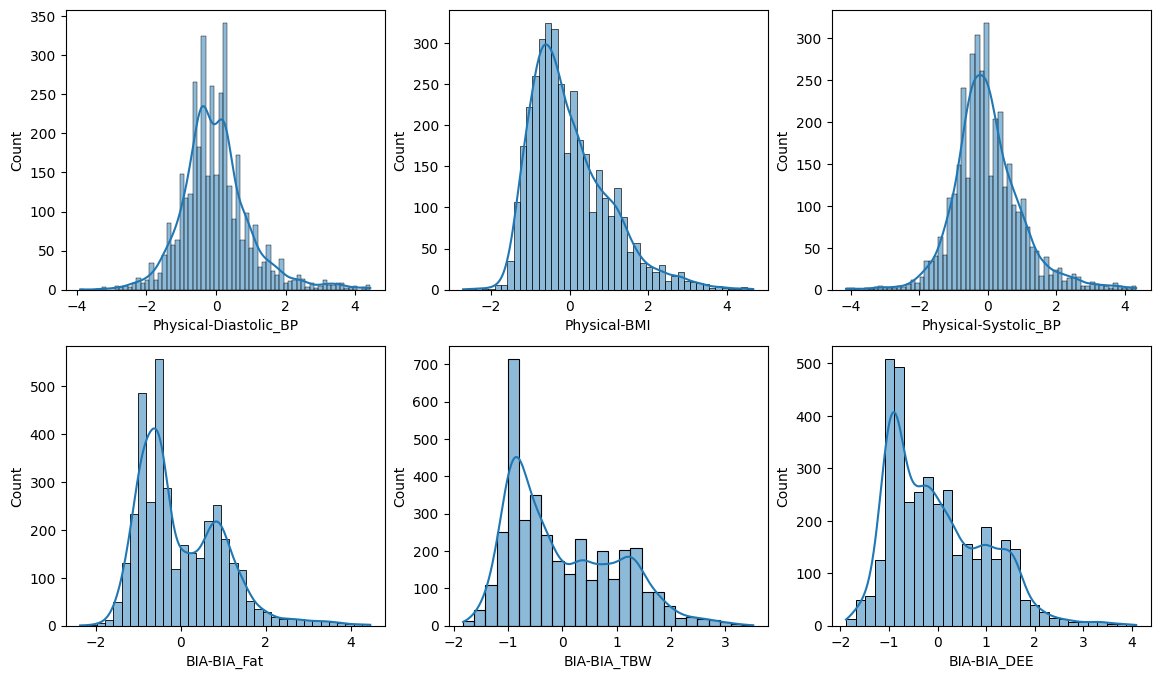

In [171]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=train_df6['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=train_df6['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=train_df6['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=train_df6['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=train_df6['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=train_df6['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Split X and Y

In [259]:
X_temp = train_df6.drop('sii', axis=1)
y_temp = train_df6['sii']

X_temp.shape, y_temp.shape

((3733, 99), (3733,))

In [267]:
X_train, X_cv, y_train, y_cv = train_test_split(X_temp.drop('id', axis=1), y_temp, test_size=0.2, random_state=42)
X_train.shape, X_cv.shape

((2986, 98), (747, 98))

# K-Means

### Calculate weights

In [268]:
zero_count = int(train_df6[train_df6['sii'] == 0.0]['sii'].value_counts().values[0])
one_count = int(train_df6[train_df6['sii'] == 1.0]['sii'].value_counts().values[0])
two_count = int(train_df6[train_df6['sii'] == 2.0]['sii'].value_counts().values[0])
three_count = int(train_df6[train_df6['sii'] == 3.0]['sii'].value_counts().values[0])
total = zero_count + one_count + two_count + three_count

zero_count, one_count, two_count, three_count, total

(1504, 672, 345, 25, 2546)

In [269]:
zero_weight = 1/(zero_count/total)
one_weight = 1/(one_count/total)
two_weight = 1/(two_count/total)
three_weight = 1/(three_count/total)

zero_weight, one_weight, two_weight, three_weight

(1.6928191489361704, 3.788690476190476, 7.379710144927536, 101.84)

### Fit

In [271]:
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=4, random_state=42)

In [272]:
train_clusters = kmeans.labels_

In [273]:
# Count points per cluster
cluster_counts = pd.Series(train_clusters).value_counts().sort_index()
print("Points per cluster:")
for cluster, count in cluster_counts.items():
   print(f"Cluster {cluster}: {count}")

Points per cluster:
Cluster 0: 449
Cluster 1: 739
Cluster 2: 669
Cluster 3: 1129


In [275]:
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
cluster_sii_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,9,215,208,17
1,283,9,0,0
2,296,308,65,0
3,619,0,0,0


In [276]:
cluster_sii_counts.columns

Index([0.0, 1.0, 2.0, 3.0], dtype='float64', name='sii')

In [296]:
# Get weighted counts for each cluster
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

weighted_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,15.235372,814.568452,1534.979710,1731.28
1,479.067819,34.098214,0.000000,0.00
2,501.074468,1166.916667,479.681159,0.00
3,1047.855053,0.000000,0.000000,0.00


In [297]:
# Get cluster mapping based on maximum weighted count
cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
cluster_to_sii_weighted

row_0
0    3.0
1    0.0
2    1.0
3    0.0
dtype: float64

### Cross-Validation

In [298]:
y_cv_predict = np.array([cluster_to_sii_weighted[x] for x in kmeans.predict(X_cv)])

In [299]:
mask = ~y_cv.isna()

accuracy_score(y_cv[mask], y_cv_predict[mask])

0.5996131528046421

In [311]:
k_range = range(2, 30)
accuracies = {}
best_acc = 0
best_k = 2

best_model = None

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)

    train_clusters = kmeans.labels_
    
    # Get cluster SII mappings
    cluster_sii_counts = pd.crosstab(train_clusters, y_train)
    weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

    # Get cluster mapping based on maximum weighted count
    cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
    
    predictions = np.array([cluster_to_sii_weighted[x] for x in kmeans.predict(X_cv)])
    
    # Calculate accuracy
    mask = ~y_cv.isna()
    acc = accuracy_score(y_cv[mask], predictions[mask])
    accuracies[k] = acc
    print(f'k={k}, accuracy={acc:.3f}')

    if acc>best_acc :
        print(f'best accuracy found = {acc}')
        best_acc = acc
        best_k = k
        best_init = init
        best_n_init = n_init

        best_model = kmeans
        
best_k, best_acc

k=2, accuracy=0.619
best accuracy found = 0.6189555125725339
k=3, accuracy=0.691
best accuracy found = 0.690522243713733
k=4, accuracy=0.600
k=5, accuracy=0.536
k=6, accuracy=0.692
best accuracy found = 0.6924564796905223
k=7, accuracy=0.700
best accuracy found = 0.7001934235976789
k=8, accuracy=0.677
k=9, accuracy=0.793
best accuracy found = 0.793036750483559
k=10, accuracy=0.801
best accuracy found = 0.8007736943907157
k=11, accuracy=0.810
best accuracy found = 0.8104448742746615
k=12, accuracy=0.807
k=13, accuracy=0.809
k=14, accuracy=0.810
k=15, accuracy=0.820
best accuracy found = 0.8201160541586073
k=16, accuracy=0.822
best accuracy found = 0.8220502901353965
k=17, accuracy=0.818
k=18, accuracy=0.805
k=19, accuracy=0.855
best accuracy found = 0.8549323017408124
k=20, accuracy=0.836
k=21, accuracy=0.789
k=22, accuracy=0.783
k=23, accuracy=0.768
k=24, accuracy=0.785
k=25, accuracy=0.791
k=26, accuracy=0.781
k=27, accuracy=0.789
k=28, accuracy=0.762
k=29, accuracy=0.750


(19, 0.8549323017408124)

In [312]:
best_model

KMeans(n_clusters=19, random_state=42)

## Test Data Prediction

In [333]:
train_clusters = best_model.labels_
    
# Get cluster SII mappings
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

In [334]:
weighted_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,15.235372,500.107143,44.278261,0.00
1,113.418883,0.000000,0.000000,0.00
2,523.081117,98.505952,0.000000,0.00
3,113.418883,109.872024,0.000000,0.00
4,140.503989,0.000000,0.000000,0.00
5,225.144947,0.000000,0.000000,0.00
6,50.784574,0.000000,0.000000,0.00
7,0.000000,0.000000,405.884058,1731.28
8,0.000000,0.000000,597.756522,0.00


In [335]:
# Get cluster mapping based on maximum weighted count
cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
cluster_to_sii_weighted

row_0
0     1.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     3.0
8     2.0
9     0.0
10    1.0
11    0.0
12    1.0
13    2.0
14    0.0
15    0.0
16    0.0
17    0.0
18    2.0
dtype: float64

In [340]:
test_predictions = {}

for index, row in test_df6.iterrows() :
    test_id = row['id']
    X_test = pd.DataFrame(row.drop('id')).T
    
    which_cluster = best_model.predict(X_test)
    predictions = cluster_to_sii_weighted[which_cluster]
    # predictions = np.array([cluster_to_sii_weighted[x] for x in best_model.predict(X_test)])
    test_predictions[test_id] = int(predictions.iloc[0])

In [341]:
test_predictions

{'00008ff9': 0,
 '000fd460': 0,
 '00105258': 0,
 '00115b9f': 0,
 '0016bb22': 0,
 '001f3379': 0,
 '0038ba98': 0,
 '0068a485': 0,
 '0069fbed': 0,
 '0083e397': 0,
 '0087dd65': 0,
 '00abe655': 0,
 '00ae59c9': 0,
 '00af6387': 0,
 '00bd4359': 0,
 '00c0cd71': 0,
 '00d56d4b': 0,
 '00d9913d': 0,
 '00e6167c': 0,
 '00ebc35d': 0}

In [343]:
pd.DataFrame.from_dict(test_predictions, orient='index', columns=['sii']).rename_axis('id').reset_index().to_csv('predictions.csv', index=False)